# Linear Modeling for Housing Price Prediction

This notebook focuses on building and evaluating linear models to predict housing prices in California. Using the cleaned dataset, it walks through:

- Preparing features and targets for modeling
- Building pipelines with transformations
- Comparing baseline and regularized regression models
- Performing hyperparameter tuning with grid search
- Analyzing model coefficients and residuals

The emphasis is on interpretability and comparison of different linear model families such as Ridge, Lasso, and ElasticNet.



Imports all necessary libraries, including those for preprocessing, model training, evaluation, and visualization. Project-specific utilities are also loaded.


In [ ]:
%load_ext autoreload
%autoreload 2

from pprint import pprint

import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    QuantileTransformer,
)


from california.config import INTERIM_DATA_FILE
from california.utils import create_coefficients_dataframe
from california.plots import (
    plot_coefficients,
    plot_compare_model_metrics,
    plot_residuals_from_estimator,
)
from california.models import (
    cross_validate_regression_model,
    grid_search_regression_model,
    organize_cv_results,
)


Loads the cleaned and preprocessed housing dataset from disk. This includes all engineered features and filtered records ready for modeling.


In [2]:
df = pd.read_parquet(INTERIM_DATA_FILE)

df.head()

,latitude,longitude,housing_median_age,total_rooms,population,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity,median_income_cat,median_house_value
0,37.88,-122.23,41,880,322,8.3252,6.984127,2.555556,0.146591,NEAR BAY,1,452600
1,37.84,-122.26,42,2555,1206,2.0804,4.294118,2.026891,0.260274,NEAR BAY,2,226700
2,37.85,-122.26,50,1120,697,2.1250,4.242424,2.640152,0.252679,NEAR BAY,2,140000
3,37.84,-122.26,50,2239,990,1.9911,5.343675,2.362768,0.203216,NEAR BAY,2,158700
4,37.85,-122.27,40,751,409,1.3578,4.524096,2.463855,0.245007,NEAR BAY,2,147500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17889 entries, 0 to 17888
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   latitude                  17889 non-null  float64 
 1   longitude                 17889 non-null  float64 
 2   housing_median_age        17889 non-null  int8    
 3   total_rooms               17889 non-null  int16   
 4   population                17889 non-null  int16   
 5   median_income             17889 non-null  float64 
 6   rooms_per_household       17889 non-null  float64 
 7   population_per_household  17889 non-null  float64 
 8   bedrooms_per_room         17889 non-null  float64 
 9   ocean_proximity           17889 non-null  category
 10  median_income_cat         17889 non-null  int32   
 11  median_house_value        17889 non-null  int32   
dtypes: category(1), float64(6), int16(2), int32(2), int8(1)
memory usage: 1.1 MB



Separates the target variable (`median_house_value`) from the predictors.


In [ ]:
target = ["median_house_value"]
features_one_hot = [
    "ocean_proximity",
    "median_income_cat",
]
features_numeric = [
    column
    for column in df.columns
    if column not in (target + features_one_hot)
]

features_to_print = [target, features_one_hot, features_numeric]

for feature in features_to_print:
    pprint(feature)

['median_house_value']
['ocean_proximity', 'median_income_cat']
['latitude',
 'longitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'median_income',
 'rooms_per_household',
 'population_per_household',
 'bedrooms_per_room']


In [5]:
X = df.drop(columns=target)
y = df[target].values.ravel()


Defines a Scikit-learn pipeline that handles preprocessing and regression in a clean and reproducible way. Includes polynomial features and scaling variants for comparison.


In [41]:
pipeline_poly = Pipeline(
    steps=[
        ("power_transformer", PowerTransformer()),
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ]
)

preprocessing_simple = ColumnTransformer(
    transformers=[
        ("num", PowerTransformer(), features_numeric),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", drop="if_binary"),
            features_one_hot,
        ),
    ],
    remainder="drop",
)

preprocessing_poly = ColumnTransformer(
    transformers=[
        ("num", pipeline_poly, features_numeric),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", drop="if_binary"),
            features_one_hot,
        ),
    ],
    remainder="drop",
)

target_transformer = QuantileTransformer(
    output_distribution="normal", random_state=42
)


Defines a dictionary of models and parameters to compare: baseline dummy regressor, OLS, Ridge, Lasso, and ElasticNet. Some models include polynomial features and scaling as part of their pipelines, and some include target transformation.


In [42]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessing_simple,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_poly": {
        "preprocessor": preprocessing_poly,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessing_simple,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
    "LinearRegression_target_poly": {
        "preprocessor": preprocessing_poly,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
    "Ridge": {
        "preprocessor": preprocessing_simple,
        "regressor": Ridge(),
        "target_transformer": None,
    },
    "Ridge_poly": {
        "preprocessor": preprocessing_poly,
        "regressor": Ridge(),
        "target_transformer": None,
    },
    "Ridge_target": {
        "preprocessor": preprocessing_simple,
        "regressor": Ridge(),
        "target_transformer": target_transformer,
    },
    "Ridge_target_poly": {
        "preprocessor": preprocessing_poly,
        "regressor": Ridge(),
        "target_transformer": target_transformer,
    },
    "Lasso": {
        "preprocessor": preprocessing_simple,
        "regressor": Lasso(),
        "target_transformer": None,
    },
    "Lasso_poly": {
        "preprocessor": preprocessing_poly,
        "regressor": Lasso(),
        "target_transformer": None,
    },
    "Lasso_target": {
        "preprocessor": preprocessing_simple,
        "regressor": Lasso(),
        "target_transformer": target_transformer,
    },
    "Lasso_target_poly": {
        "preprocessor": preprocessing_poly,
        "regressor": Lasso(),
        "target_transformer": target_transformer,
    },
    "ElasticNet": {
        "preprocessor": preprocessing_simple,
        "regressor": ElasticNet(),
        "target_transformer": None,
    },
    "ElasticNet_poly": {
        "preprocessor": preprocessing_poly,
        "regressor": ElasticNet(),
        "target_transformer": None,
    },
    "ElasticNet_target": {
        "preprocessor": preprocessing_simple,
        "regressor": ElasticNet(),
        "target_transformer": target_transformer,
    },
    "ElasticNet_target_poly": {
        "preprocessor": preprocessing_poly,
        "regressor": ElasticNet(),
        "target_transformer": target_transformer,
    },
}


Performs cross-validation for each model defined above using a shared pipeline. Results are collected for evaluation.


In [43]:
results = {
    model_name: cross_validate_regression_model(X, y, **classifier)
    for model_name, classifier in regressors.items()
}

df_results = organize_cv_results(results)

df_results

/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.324e+12, tolerance: 1.295e+10
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.286e+12, tolerance: 1.303e+10
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.00186,0.00183,-0.000654,-75966.60759,-95675.18693,0.003691
1,DummyRegressor,0.001738,0.001919,-0.000398,-75832.432601,-94467.197536,0.003657
2,DummyRegressor,0.001888,0.001823,-0.000009,-74851.688406,-93978.824732,0.003711
3,DummyRegressor,0.001773,0.002011,-0.000052,-77050.183031,-96858.605837,0.003783
4,DummyRegressor,0.002605,0.001573,-0.000261,-75878.31092,-95130.339097,0.004178
...,...,...,...,...,...,...,...
80,ElasticNet_target_poly,0.204687,0.021453,0.073805,-70048.555392,-92046.795113,0.22614
81,ElasticNet_target_poly,0.195434,0.021543,0.086966,-69395.137162,-90248.115636,0.216977
82,ElasticNet_target_poly,0.221224,0.023093,0.076245,-68856.520417,-90324.680814,0.244318
83,ElasticNet_target_poly,0.195236,0.019717,0.076162,-71030.434122,-93094.65912,0.214953


In [44]:
df_results.groupby("model").mean().sort_values("test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
Lasso_target_poly,0.21903,0.020265,-0.035837,-74528.218929,-96900.627571,0.239295
Lasso_target,0.195375,0.013525,-0.035837,-74528.218929,-96900.627571,0.2089
DummyRegressor,0.001973,0.001831,-0.000275,-75915.84451,-95222.030826,0.003804
ElasticNet_target,0.204881,0.012746,0.081108,-69725.01353,-91266.635154,0.217627
ElasticNet_target_poly,0.20521,0.020977,0.081108,-69725.01353,-91266.635154,0.226187
ElasticNet,0.234134,0.011985,0.521702,-50063.239159,-65842.093231,0.246119
ElasticNet_poly,0.2126,0.018218,0.592622,-45622.364067,-60760.503466,0.230819
LinearRegression,0.127083,0.00741,0.606436,-44224.719423,-59720.875865,0.134493
Lasso,0.384955,0.013217,0.606437,-44224.657266,-59720.865375,0.398172


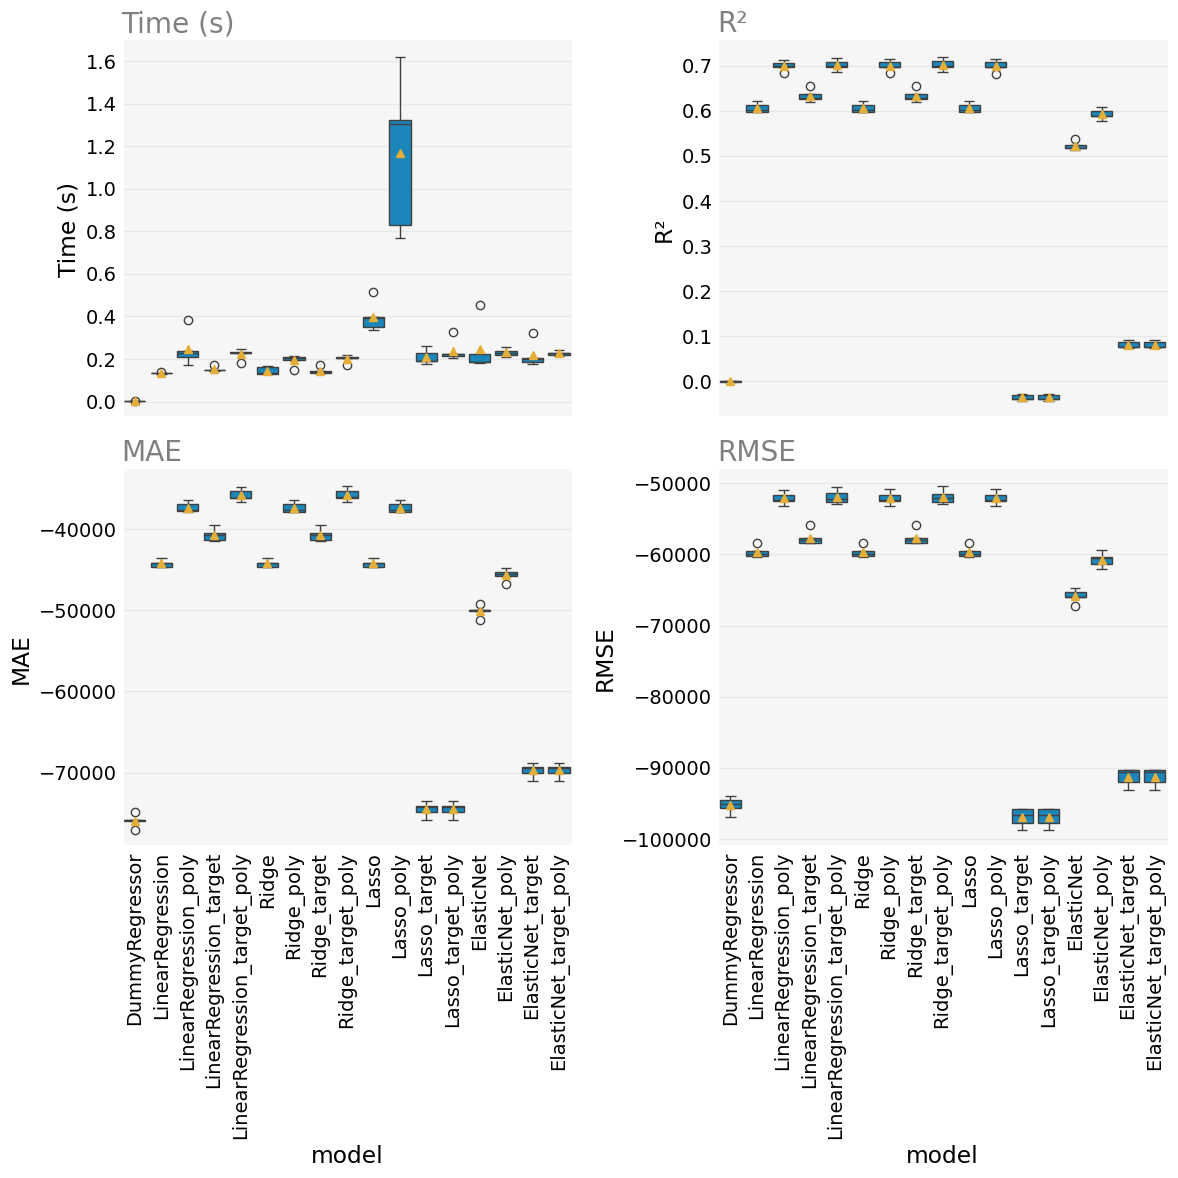

In [66]:
plot_compare_model_metrics(df_results, figsize=(12, 12))

We can see that some of the variants perform better than others. Since ElasticNet is a combination of Lasso and Ridge, we can do an exhaustive search for the best parameters using grid search. This will help us find the optimal alpha and l1_ratio for ElasticNet. And maybe we can have a result that is as good as the best performing models above or even better, but with a more interpretable model.


In [45]:
elasticnet_regressor = ElasticNet()

param_grid = {
    "regressor__reg__alpha": [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0, 5.0, 10.0],
    "regressor__reg__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
    "regressor__preprocessor": [
        preprocessing_simple,
        preprocessing_poly,
    ],
    "transformer": [None, target_transformer],
}

grid_search = grid_search_regression_model(
    regressor=elasticnet_regressor,
    param_grid=param_grid,
    preprocessor=preprocessing_simple,
    target_transformer=target_transformer,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('num',
                                                                                                              PowerTransformer(),
                                                                                                              ['latitude',
                                                                                                               'longitude',
                                                                                                               'housing_median_age',
                                                                                                               'total_rooms',
                                                                                                               'population',
                                                                                                               'median_income',
                                                                                                               'rooms_per_household',
                                                                                                               'population_per_household',
                                                                                                               'bedrooms_per...
                                                                                      ['ocean_proximity',
                                                                                       'median_income_cat'])])],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 5.0, 10.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9],
                         'transformer': [None,
                                         QuantileTransformer(output_distribution='normal',
                                                             random_state=42)]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [46]:
grid_search.fit(X, y)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.659e+12, tolerance: 1.306e+10
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.158e+11, tolerance: 1.298e+10
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('num',
                                                                                                              PowerTransformer(),
                                                                                                              ['latitude',
                                                                                                               'longitude',
                                                                                                               'housing_median_age',
                                                                                                               'total_rooms',
                                                                                                               'population',
                                                                                                               'median_income',
                                                                                                               'rooms_per_household',
                                                                                                               'population_per_household',
                                                                                                               'bedrooms_per...
                                                                                      ['ocean_proximity',
                                                                                       'median_income_cat'])])],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 5.0, 10.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9],
                         'transformer': [None,
                                         QuantileTransformer(output_distribution='normal',
                                                             random_state=42)]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)


Displays the best parameters, score, and estimator returned from grid search.


In [47]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('power_transformer',
                                                   PowerTransformer()),
                                                  ('poly_features',
                                                   PolynomialFeatures(include_bias=False))]),
                                  ['latitude', 'longitude', 'housing_median_age',
                                   'total_rooms', 'population', 'median_income',
                                   'rooms_per_household',
                                   'population_per_household',
                                   'bedrooms_per_room']),
                                 ('cat',
                                  OneHotEncoder(drop='if_binary',
                                                handle_unknown='ignore'),
                                  ['ocean_proximity', 'median_income_cat'])]),
 'regressor__reg__alpha'

In [48]:
grid_search.best_score_

np.float64(-52102.15490753017)

In [49]:
grid_search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('power_transformer',
                                                                                                        PowerTransformer()),
                                                                                                       ('poly_features',
                                                                                                        PolynomialFeatures(include_bias=False))]),
                                                                                       ['latitude',
                                                                                        'longitude',
                                                                                        'housing_median_age',
                                                                                        'total_rooms',
                                                                                        'population',
                                                                                        'median_income',
                                                                                        'rooms_per_household',
                                                                                        'population_per_household',
                                                                                        'bedrooms_per_room']),
                                                                                      ('cat',
                                                                                       OneHotEncoder(drop='if_binary',
                                                                                                     handle_unknown='ignore'),
                                                                                       ['ocean_proximity',
                                                                                        'median_income_cat'])])),
                                                     ('reg',
                                                      ElasticNet(alpha=0.01,
                                                                 l1_ratio=0.1))]),
                           transformer=QuantileTransformer(output_distribution='normal',
                                                           random_state=42))


Extracts feature coefficients from the best model for interpretability. Useful to understand which features the model relies on most.


In [50]:
coefs = create_coefficients_dataframe(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coefficient
cat__ocean_proximity_INLAND,-0.581847
cat__median_income_cat_3,-0.426323
num__latitude^2,-0.247296
num__population_per_household,-0.243738
num__housing_median_age population_per_household,-0.083464
...,...
cat__ocean_proximity_<1H OCEAN,0.121574
cat__median_income_cat_1,0.227535
cat__median_income_cat_2,0.239879
cat__ocean_proximity_NEAR OCEAN,0.294017


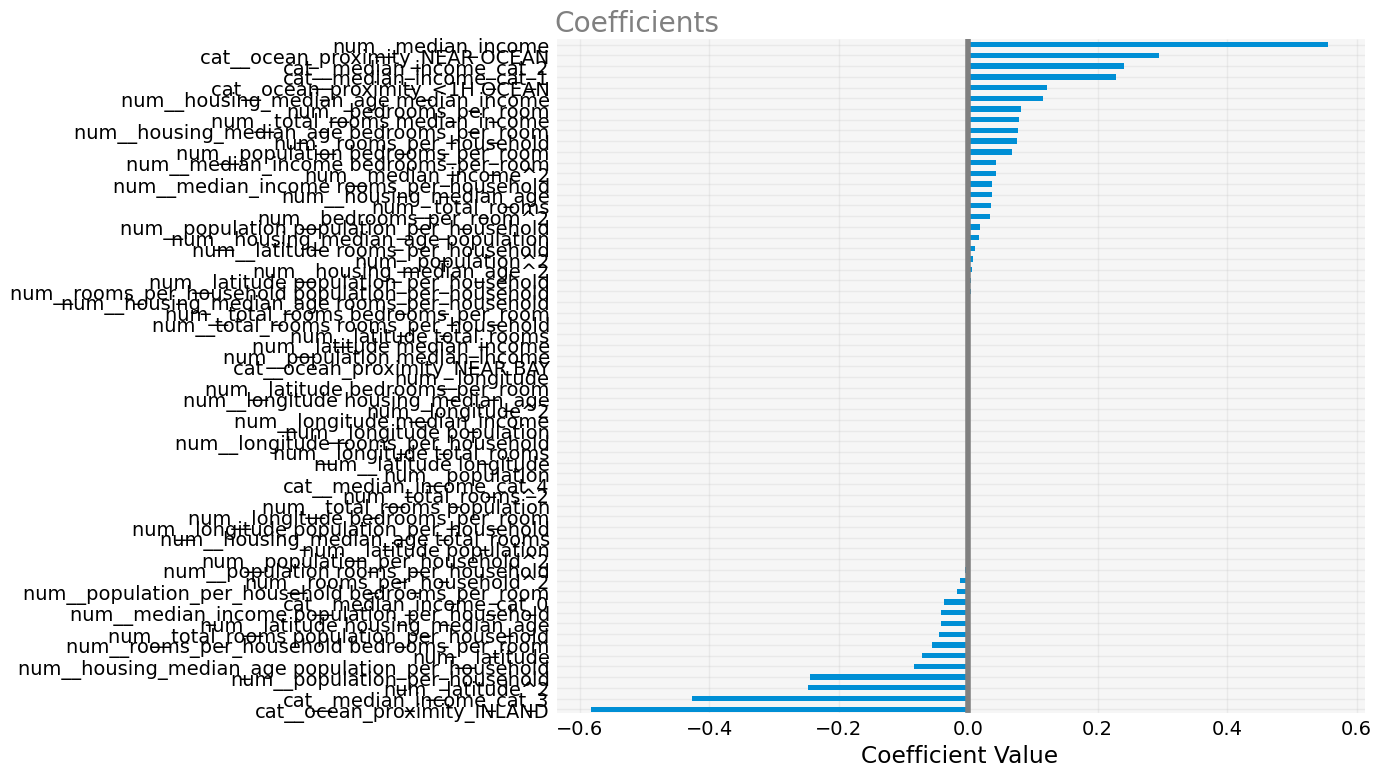

In [51]:
plot_coefficients(coefs)


Identifies coefficients close to zero, which might indicate weak predictors or regularization effects.


In [52]:
low_value_coefs = coefs["coefficient"].between(-0.1, 0.1)

low_value_coefs

cat__ocean_proximity_INLAND                         False
cat__median_income_cat_3                            False
num__latitude^2                                     False
num__population_per_household                       False
num__housing_median_age population_per_household     True
                                                    ...  
cat__ocean_proximity_<1H OCEAN                      False
cat__median_income_cat_1                            False
cat__median_income_cat_2                            False
cat__ocean_proximity_NEAR OCEAN                     False
num__median_income                                  False
Name: coefficient, Length: 63, dtype: bool


Replots coefficients excluding near-zero values to better highlight influential features.

We see that the most positive coefficient is for `median_income`, while the most negative is for `ocean_proximity_[INLAND]`. This aligns with our expectations based on domain knowledge, where higher income generally leads to higher housing prices, and proximity to the ocean is a strong positive factor.



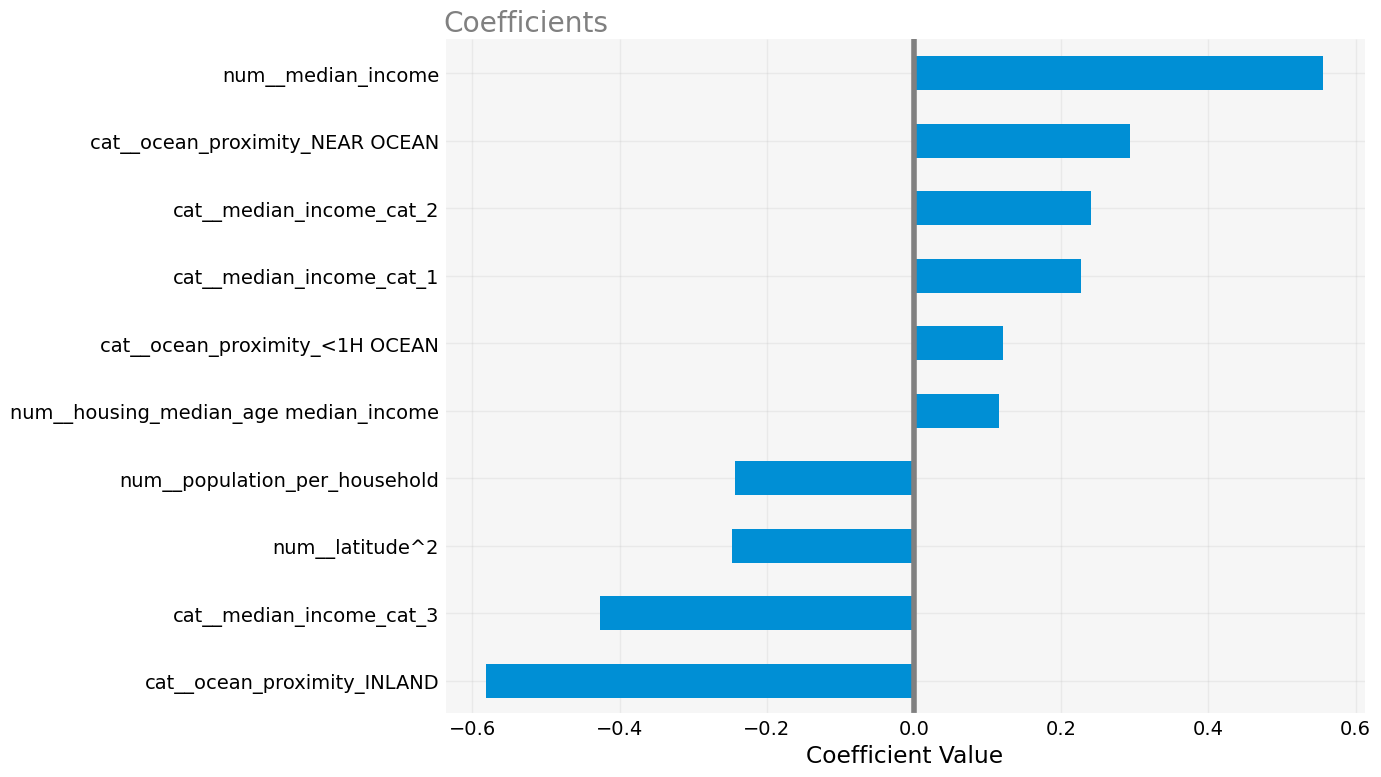

In [53]:
plot_coefficients(
    coefs[~low_value_coefs]
)


Plots the residuals from the best model to visually assess fit quality and check for model biases or patterns.


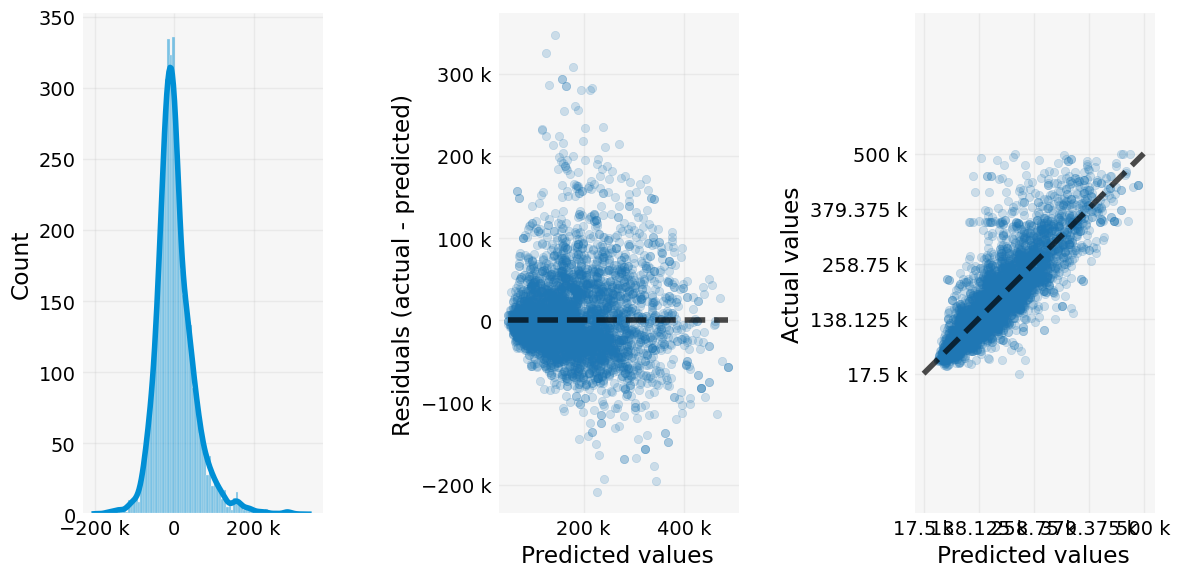

In [54]:
plot_residuals_from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    eng_formatter=True,
)

Let's repeat the steps for Ridge regression.

In [55]:
ridge_regressor = Ridge()

param_grid = {
    "regressor__reg__alpha": [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0, 5.0, 10.0],
    "regressor__preprocessor": [
        preprocessing_simple,
        preprocessing_poly,
    ],
    "transformer": [None, target_transformer],
}

grid_search = grid_search_regression_model(
    regressor=ridge_regressor,
    param_grid=param_grid,
    preprocessor=preprocessing_simple,
    target_transformer=target_transformer,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('num',
                                                                                                              PowerTransformer(),
                                                                                                              ['latitude',
                                                                                                               'longitude',
                                                                                                               'housing_median_age',
                                                                                                               'total_rooms',
                                                                                                               'population',
                                                                                                               'median_income',
                                                                                                               'rooms_per_household',
                                                                                                               'population_per_household',
                                                                                                               'bedrooms_per...
                                                                                      OneHotEncoder(drop='if_binary',
                                                                                                    handle_unknown='ignore'),
                                                                                      ['ocean_proximity',
                                                                                       'median_income_cat'])])],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 5.0, 10.0],
                         'transformer': [None,
                                         QuantileTransformer(output_distribution='normal',
                                                             random_state=42)]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [56]:
grid_search.fit(X, y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('num',
                                                                                                              PowerTransformer(),
                                                                                                              ['latitude',
                                                                                                               'longitude',
                                                                                                               'housing_median_age',
                                                                                                               'total_rooms',
                                                                                                               'population',
                                                                                                               'median_income',
                                                                                                               'rooms_per_household',
                                                                                                               'population_per_household',
                                                                                                               'bedrooms_per...
                                                                                      OneHotEncoder(drop='if_binary',
                                                                                                    handle_unknown='ignore'),
                                                                                      ['ocean_proximity',
                                                                                       'median_income_cat'])])],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 5.0, 10.0],
                         'transformer': [None,
                                         QuantileTransformer(output_distribution='normal',
                                                             random_state=42)]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [57]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('power_transformer',
                                                   PowerTransformer()),
                                                  ('poly_features',
                                                   PolynomialFeatures(include_bias=False))]),
                                  ['latitude', 'longitude', 'housing_median_age',
                                   'total_rooms', 'population', 'median_income',
                                   'rooms_per_household',
                                   'population_per_household',
                                   'bedrooms_per_room']),
                                 ('cat',
                                  OneHotEncoder(drop='if_binary',
                                                handle_unknown='ignore'),
                                  ['ocean_proximity', 'median_income_cat'])]),
 'regressor__reg__alpha'

In [58]:
grid_search.best_score_

np.float64(-51943.397754600854)

In [59]:
grid_search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('power_transformer',
                                                                                                        PowerTransformer()),
                                                                                                       ('poly_features',
                                                                                                        PolynomialFeatures(include_bias=False))]),
                                                                                       ['latitude',
                                                                                        'longitude',
                                                                                        'housing_median_age',
                                                                                        'total_rooms',
                                                                                        'population',
                                                                                        'median_income',
                                                                                        'rooms_per_household',
                                                                                        'population_per_household',
                                                                                        'bedrooms_per_room']),
                                                                                      ('cat',
                                                                                       OneHotEncoder(drop='if_binary',
                                                                                                     handle_unknown='ignore'),
                                                                                       ['ocean_proximity',
                                                                                        'median_income_cat'])])),
                                                     ('reg', Ridge())]),
                           transformer=QuantileTransformer(output_distribution='normal',
                                                           random_state=42))

In [60]:
coefs = create_coefficients_dataframe(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coefficient
num__total_rooms,-0.738400
num__population_per_household,-0.557064
cat__ocean_proximity_INLAND,-0.542539
cat__median_income_cat_3,-0.489075
num__latitude^2,-0.304761
...,...
cat__median_income_cat_1,0.401241
cat__median_income_cat_2,0.433392
num__rooms_per_household,0.434452
num__median_income,0.560922


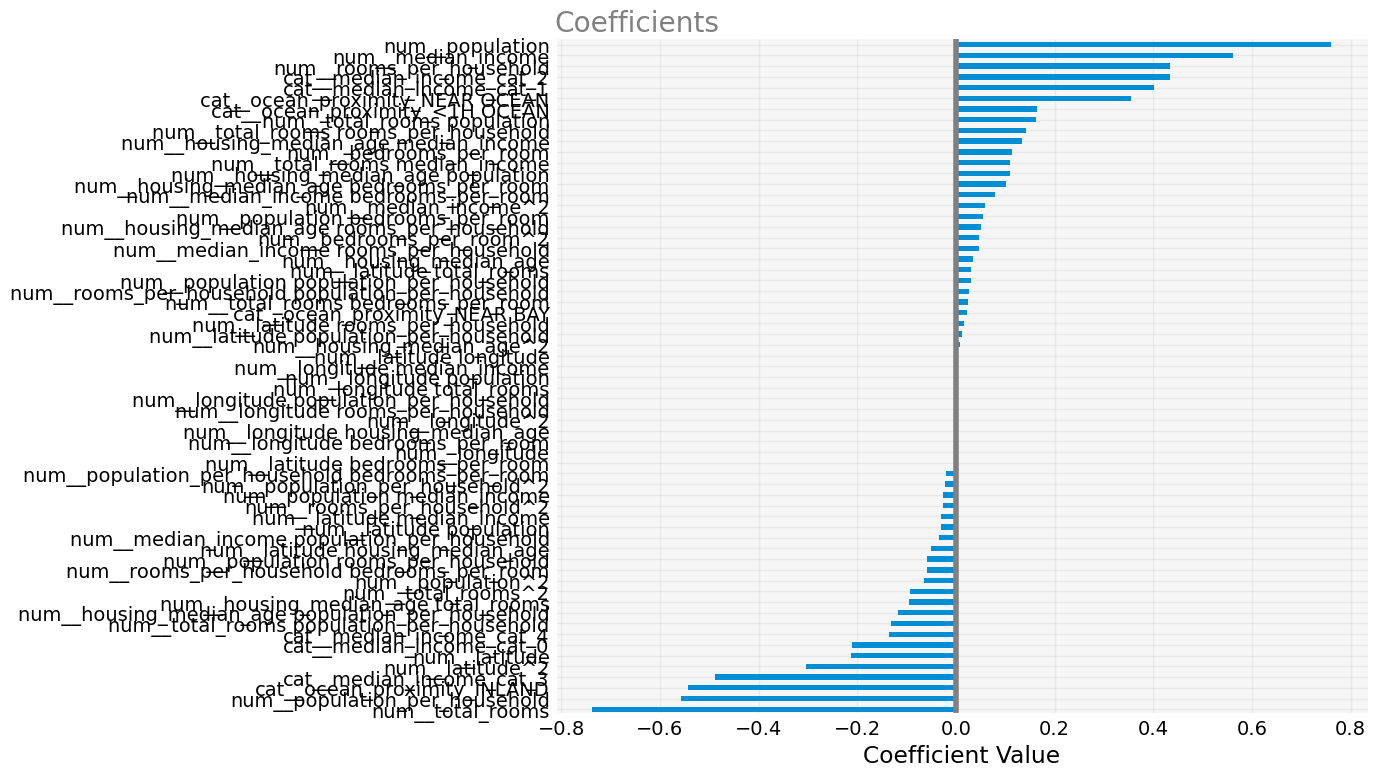

In [61]:
plot_coefficients(coefs)

In [62]:
low_value_coefs = coefs["coefficient"].between(-0.1, 0.1)

low_value_coefs

num__total_rooms                 False
num__population_per_household    False
cat__ocean_proximity_INLAND      False
cat__median_income_cat_3         False
num__latitude^2                  False
                                 ...  
cat__median_income_cat_1         False
cat__median_income_cat_2         False
num__rooms_per_household         False
num__median_income               False
num__population                  False
Name: coefficient, Length: 63, dtype: bool

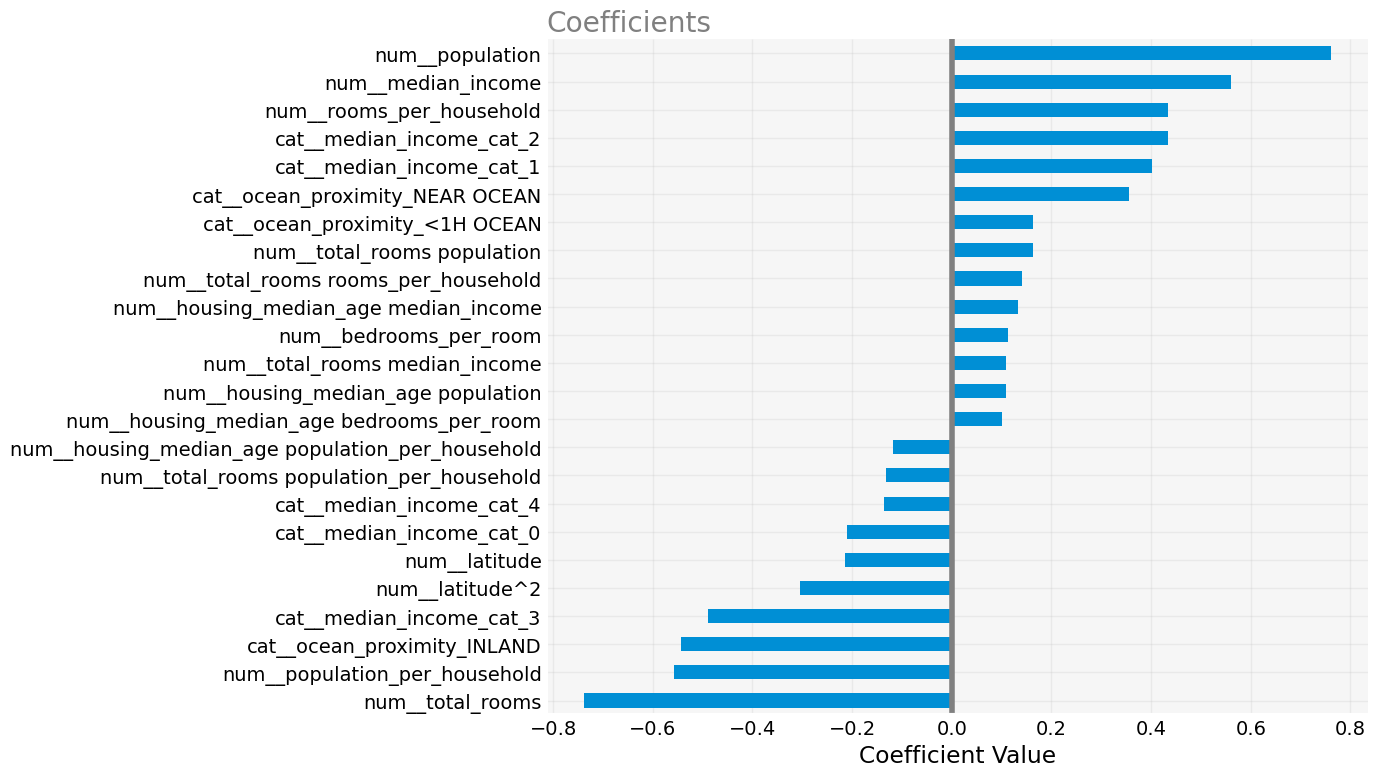

In [63]:
plot_coefficients(
    coefs[~low_value_coefs]
)

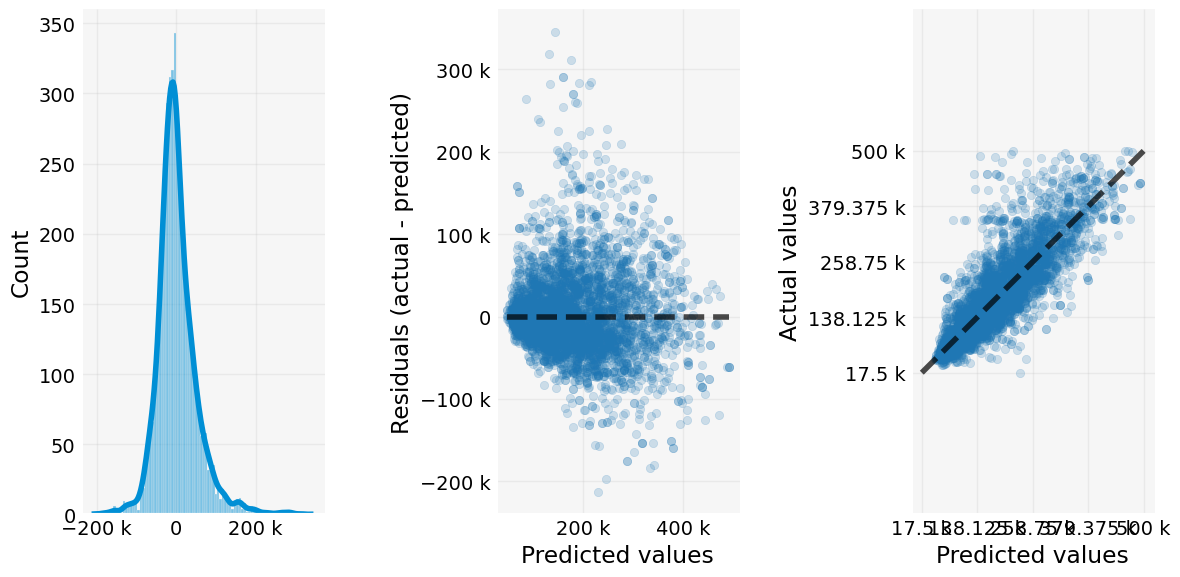

In [64]:
plot_residuals_from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    eng_formatter=True,
)